# Imports

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [256]:
from sklearn.svm import SVR

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [10]:
from keras.models import load_model

In [11]:
import xgboost as xgb

In [4]:
import h5py

/Users/solo/.pyenv/versions/jupyter3.6.4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Read

In [12]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample_submission = pd.read_csv('./sample_submission.csv')

In [13]:
train.head(1)

,Word,Label
0,Аалтонен,1


In [14]:
test.head(1)

,Word
0,Аалто


In [15]:
print('1:{}\n0:{}'.format(train[train['Label']==1].shape, train[train['Label']==0].shape))

1:(10638, 2)
0:(90770, 2)


In [16]:
print(train.shape, test.shape)

(101408, 2) (188920, 1)


In [410]:
# не фамилии и таких много =\
train.iloc[[1320, 1363, 1523]]

,Word,Label
1320,акт,1
1363,активисты,1
1523,алгоритмы,1


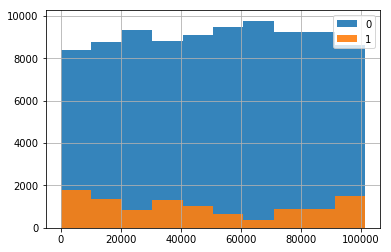

In [183]:
plt.hist(train[train['Label']==0].index, alpha=0.9, label='0')
plt.hist(train[train['Label']==1].index, alpha=0.9, label='1')
# plt.hist(rows_w_ss, alpha=0.3, label='ss')
plt.grid(True)
plt.legend(loc='upper right')

# TF

In [6]:
tokenizer = Tokenizer(num_words=None, lower=True,)
tokenizer.fit_on_texts(train['Word'])

In [7]:
x_train = tokenizer.texts_to_matrix(train['Word'], mode='binary')
x_test = tokenizer.texts_to_matrix(test['Word'], mode='binary')

In [8]:
num_classes = 2
max_words = x_train.shape[1]
batch_size = 128
epochs = 1

In [9]:
x_train.shape

(101408, 88335)

In [10]:
y_train = keras.utils.to_categorical(train['Label'], num_classes)

In [11]:
model = Sequential([
        Dense(1024, input_shape=(max_words,)),
          Activation('relu'),
          Dropout(0.5),
          Dense(num_classes),
          Activation('softmax')
        ])

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 91267 samples, validate on 10141 samples
Epoch 1/1
91267/91267 [==============================] - 1358s 15ms/step - loss: 0.3319 - acc: 0.8993 - val_loss: 0.4250 - val_acc: 0.8505


In [16]:
model.save('1e_model_dump.h5')

In [11]:
model = load_model('1e_model_dump.h5')

In [12]:
predo = model.predict(x_test, verbose=1)

188920/188920 [==============================] - 648s 3ms/step


In [15]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
predomax = np.argmax(predo, axis=1)

In [20]:
ttest = test.copy()

In [23]:
ttest['Label'] = pd.DataFrame({'Label':predomax})

In [25]:
ttest.describe()

,Label
count,188920.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


# XGB

## Encode

In [119]:
def encode_frame(frame):
    test_fr = frame.copy()
    test_fr['len'] = test_fr['Word'].apply(lambda x: len(x))
    test_fr['Word'] = test_fr['Word'].apply(lambda x: x.lower())
    for n_col in cols_w:
        test_fr[n_col] = 0
    for index, row in test_fr.iterrows():
        if (index % 1000) == 0: print(index, '\t', row['Word'])
        for char in set(row['Word']):
            if char in chars_cols:
                test_fr.loc[index, char] += 1
    test_fr = test_fr.fillna(0)
    test_fr = test_fr.drop(['Word'], axis=1)
    return test_fr

In [177]:
for ito in range(max_len):
    test_fr[ito] = None

In [185]:
encoded_x = test_fr.drop(['Label'], axis=1).as_matrix()
encoded_y = test_fr['Label'].as_matrix().reshape(test_fr.shape[0],)

In [335]:
cols_w_list

[' ',
 '"',
 '&',
 "'",
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '7',
 '\\',
 '`',
 '\xa0',
 '«',
 '·',
 '»',
 'Ó',
 'á',
 'é',
 'ë',
 'ó',
 'ô',
 'Ё',
 'А',
 'Б',
 'В',
 'Г',
 'Д',
 'Е',
 'Ж',
 'З',
 'И',
 'Й',
 'К',
 'Л',
 'М',
 'Н',
 'О',
 'П',
 'Р',
 'С',
 'Т',
 'У',
 'Ф',
 'Х',
 'Ц',
 'Ч',
 'Ш',
 'Щ',
 'Ъ',
 'Ы',
 'Ь',
 'Э',
 'Ю',
 'Я',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ѐ',
 'ё',
 '’',
 '“',
 '”']

In [392]:
def fit_encoder(train, test):
    cols_w = set()
    for word in train['Word'].values:
        cols_w.update(set(word))
    for word in test['Word'].values:
        cols_w.update(set(word))
    cols_w.update(set(map(str, range(0, 39))))
    cols_w_list = list(cols_w)
    cols_w_list.sort()
    label_encoder_x = LabelEncoder()
    _ = label_encoder_x.fit(cols_w_list)
    return label_encoder_x

In [349]:
def label_encode_chars(frame, label_encoder_x):
    print("------LabelEncoder------")
    array_list = []
    matrix_x = frame.as_matrix()
    for itero in range(matrix_x.shape[1]):
        array_list.append(label_encoder_x.transform(matrix_x[:,itero].astype(str)))
    matr_enc_x = np.array(array_list).T
    print("------DONE------")
    return matr_enc_x

In [379]:
def words_to_features(frame):
    test_fr = frame.copy()
    test_fr['len'] = test_fr['Word'].apply(lambda x: len(x))
    dicts_list = []
    for index, row in test_fr.iterrows():
        if (index % 1000) == 0: print(index, '\t', row['Word'])
        dicts_list.append({k: v for k, v in enumerate(row['Word'])})
    test_fr = pd.concat([test_fr, pd.DataFrame(dicts_list)], axis=1)
    test_fr = test_fr.drop(['Word'], axis=1)
    if test_fr.shape[1] < 39:
        for ite in range(31, 38):
            test_fr[ite] = None
    test_fr = test_fr.fillna(0)
    return test_fr

In [393]:
label_encoder_x = fit_encoder(train, test)

In [383]:
encoded_y = train['Label'].as_matrix().reshape(train.shape[0],)

In [322]:
encoded_x.shape

(101408, 39)

In [394]:
chars_train = words_to_features(train.drop(['Label'], axis=1))

0 	 Аалтонен
1000 	 азами
2000 	 амилоида
3000 	 арабиста
4000 	 аудиториях
5000 	 Бармена
6000 	 Бендиго
7000 	 благоволением
8000 	 БОРИСОВИЧ
9000 	 брюхами
10000 	 Валенсией
11000 	 Вероотступничество
12000 	 винтику
13000 	 Войлоки
14000 	 Вудраффом
15000 	 Гавот
16000 	 геологам
17000 	 ГНОМАХ
18000 	 Градиент
19000 	 гуманизмом
20000 	 Деймона
21000 	 Джадкинса
22000 	 дисплазия
23000 	 Дорин
24000 	 Евангелиях
25000 	 житиях
26000 	 закреплении
27000 	 захоронениями
28000 	 зёрнышку
29000 	 имманентность
30000 	 информативность
31000 	 Кадету
32000 	 Карамазов
33000 	 квалификатора
34000 	 класса
35000 	 колесику
36000 	 конголезцам
37000 	 КОРАБЛЕКРУШЕНИЕ
38000 	 красавицах
39000 	 Кудеснику
40000 	 Лампедузы
41000 	 Ливингстона
42000 	 лососины
43000 	 Макаровна
44000 	 масленицу
45000 	 Меррит
46000 	 Миннесоту
47000 	 монеток
48000 	 мушках
49000 	 намотке
50000 	 Невод
51000 	 несоответствие
52000 	 носов
53000 	 обращение
54000 	 оккупацию
55000 	 органон
56000 	 отказнико

In [395]:
encoded_x = label_encode_chars(chars_train, label_encoder_x)

------LabelEncoder------
------DONE------


In [267]:
joblib.dump(encoded_x, './train_encoded_x_char.pkl')

['./train_encoded_x_char.pkl']

In [128]:
train_encoded_x = joblib.load('./train_encoded_x_ss.pkl')

## Train

In [396]:
seed = 88
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(encoded_x, encoded_y, 
                                                    test_size=test_size, random_state=seed)

In [259]:
positive_cases = train[train['Label']==1].shape[0]
negative_cases = train[train['Label']==0].shape[0]
scale_pos_weight = negative_cases / positive_cases

In [260]:
scale_pos_weight

8.532618913329573

In [397]:
gbm = xgb.XGBClassifier(max_depth=50, n_estimators=1000, learning_rate=0.05, n_jobs=7, 
                        random_state=88, scale_pos_weight=scale_pos_weight)

In [325]:
print(y_train.shape, y_train.sum())

(81126,) 8566


In [398]:
gbm.fit(encoded_x, encoded_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=50, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=7, nthread=None, objective='binary:logistic',
       random_state=88, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=8.532618913329573, seed=None, silent=True,
       subsample=1)

In [399]:
joblib.dump(gbm, './gbm50.1000.88.chars.all.pkl')

['./gbm50.1000.88.chars.all.pkl']

## Predict

In [400]:
chars_train = words_to_features(test)

0 	 Аалто
1000 	 автомобильчик
2000 	 Айдына
3000 	 Алика
4000 	 ампутацией
5000 	 антимиры
6000 	 аристократом
7000 	 Астронавт
8000 	 Бааде
9000 	 Бандой
10000 	 Батталья
11000 	 белизна
12000 	 бессмертникам
13000 	 благах
14000 	 Богини
15000 	 Борисюк
16000 	 Брею
17000 	 Букета
18000 	 бытием
19000 	 Вартан
20000 	 Венец
21000 	 вечерю
22000 	 Вилу
23000 	 внутренностей
24000 	 вокодерах
25000 	 восприятие
26000 	 Въезда
27000 	 Вырывание
28000 	 гаитянки
29000 	 гвалте
30000 	 герцог
31000 	 Гладков
32000 	 Голосовании
33000 	 Господи
34000 	 грешница
35000 	 Гужона
36000 	 датировке
37000 	 Декадент
38000 	 деревцом
39000 	 Джермейн
40000 	 дилерств
41000 	 Добавлением
42000 	 Домициль
43000 	 Дрезин
44000 	 дышлу
45000 	 Еретиков
46000 	 жизням
47000 	 завышении
48000 	 законодатели
49000 	 ЗАПРАВКА
50000 	 Заявками
51000 	 Змеек
52000 	 Идеализм
53000 	 ИЗОБРАЖЕНИЯМ
54000 	 инвертированию
55000 	 инструменту
56000 	 Исидора
57000 	 Ишаки
58000 	 Каллаган
59000 	 капитала
6000

In [401]:
test_encoded_x = label_encode_chars(chars_train, label_encoder_x)

------LabelEncoder------
------DONE------


In [402]:
# last
test_encoded_x

array([[ 41,  59,  91, ...,   7,   7,   7],
       [ 30,  59,  59, ...,   7,   7,   7],
       [ 40,  59,  91, ...,   7,   7,   7],
       ...,
       [ 43,  58, 103, ...,   7,   7,   7],
       [ 44, 124, 103, ...,   7,   7,   7],
       [ 44, 124, 103, ...,   7,   7,   7]])

In [300]:
joblib.dump(test_encoded_x, './test_encoded_x_chars.pkl')

['./test_encoded_x_chars.pkl']

In [140]:
test_encoded_x = joblib.load('./test_encoded_x_ss.pkl')

In [248]:
gbm = joblib.load('./gbm30.900.88.pkl')

In [403]:
predictions = gbm.predict(test_encoded_x)

/Users/solo/.pyenv/versions/jupyter3.6.4/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [387]:
roc_auc_score(encoded_y, predictions)

0.9960118982042525

In [291]:
roc_auc_score(y_test, predictions)

0.7581622013870777

In [303]:
test.index.shape

(188920,)

In [311]:
test_encoded_x.shape

(188920, 39)

In [404]:
submission = pd.DataFrame({'Id': test.index,
                           'Prediction': predictions })

In [405]:
submission.to_csv('./submission30.900.88.chars.csv', index=False)

# SVM

In [257]:
svr_rbf = SVR(kernel='rbf', C=1500, gamma=0.1)

In [ ]:
svrB2C = svr_rbf.fit(X_train, y_train)


In [ ]:
joblib.dump(svrB2C, './svr{}.{}.pkl'.format(1500,0.1))


In [ ]:
resultB2C = svrB2C.predict(train_encoded_x)

In [ ]:
roc_auc_score(encoded_y, resultB2C)